In [1]:
!pip install imblearn -q
!pip install spacy -q
!python -m spacy download en_core_web_sm -q

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2023-04-08 13:07:25.335155: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-04-08 13:07:25.335177: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-08 13:07:27.467265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2023-04-08 13:07:27.467688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2023-04-08 13:07:27.468100: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2023-04-08 13:07:27.527702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cu

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Предобработка-текста" data-toc-modified-id="Предобработка-текста-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предобработка текста</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Decision-Tree-Classifier" data-toc-modified-id="Decision-Tree-Classifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Decision Tree Classifier</a></span></li><li><span><a href="#Random-Forest-Classifier" data-toc-modified-id="Random-Forest-Classifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Random Forest Classifier</a></span></li><li><span><a href="#Cat-Boost-Classifier" data-toc-modified-id="Cat-Boost-Classifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Cat Boost Classifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import re
import os
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
import nltk
import transformers
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import (
    cross_val_score,
    train_test_split
)

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
from sklearn.model_selection import (
    RandomizedSearchCV,
    GridSearchCV
)
from scipy.stats import randint
import torch
import transformers as ppb
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
    precision_recall_curve
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
import spacy

pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 5

Загрузим данные и отберем из них случайным образом `55000` строк, чтобы процесс обучения не занимал много времени. 

In [3]:
path_yandex = '/datasets/toxic_comments.csv'    
path = 'C:/Users/nedel/Desktop/Projects/toxic_comments.csv'

if os.path.exists(path):
    df = pd.read_csv(path, index_col=[0])
    df.info()
    print('Дубликаты:', df.duplicated().sum())
    display(df.sample(15))
elif os.path.exists(path_yandex):
    df = pd.read_csv(path_yandex, index_col=[0])
    df.info()
    print('Дубликаты:', df.duplicated().sum())
    display(df.sample(15))
else:
    print('Ошибка в считывании данных')
    
# Отберем 55000 строк случайным образом    
df = df.sample(55000, random_state=RANDOM_STATE)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB
Дубликаты: 0


,text,toxic
64522,in Japanese education,0
19725,"Updating links?\nI've posted a message at Talk:Washington#Automated hints to disambiguate Washington links concerning the fixes that will have to be done as a result of the move, as well as hints for automated tools.",0
12000,Anyone notice that is a copy of the Geography section of the Morocco page in the CIA World Factbook?,0
23799,"Hi, unfortunately another 'new' user named WikiBotBot has re-added contentious material to the iERA article and removed well sourced material. I am getting rather frustrated with the lack of interaction on the talk page. Is there a process to get issues such as this resolved (e.g. an arbitrator)? If so, could you direct me to one and I can ask for assistance? Many thanks",0
17560,""". Might fall under """"trivia"""" / """"In Popular Culture"""" category""",0
13840,"Evil Ernie Revert \n\nI had reverted the Evil Ernie article to it's previous version because it was a copyright violation, as the portion I removed was lifted in it's entirety from the Chaos Comics Evil Ernie Bio. I attempted to do so in accordance as per the instructions at Wikipedia:Copyright problems. Is there something I missed?",0
135180,"Your input requested \n\nI'm new here, but I think your dead-on regarding the disambiguation of Chinaman. I'd love to read your take on the controversy at the Oriental article.",0
11988,"""\n\n Helly Jimmy, well; fuck you. \n\nAccording to Wikipedia talk:No legal threats; people shouldn't say to one another """"what you do is supporting terrorism, and you should be judged front of law"""".\n\nOn the other hand, we can say """"fuck you"""" and the punishment for that is only two weeks. Well it's okay for me to get away from wikipedia for two weeks; and I'm willing to curse to you. \n\nFuck you Jimmy Wales. Your stupid """"eye"""" showing video about begging money for Wikipedia was stupidest thing I have ever seen.\n\nOnce again; """"Fuck you"""", """"Fuck you"""", and """"Fuck you"""".\n\nNow go ahead with your """"Wikilobbying"""" idiot members and have fun.\n\nI just wanted to get this out and get my """"wikipedia legal"""" two week ban.\n\nFuck you; you dumb idiot. """,1
65172,waste of skin who should be put down before he procreates,0
154638,"But I am not saying that quantum aetherdynamcis is true. I am just saying what has been documented about it, by sources that are independent from Wikipedia and reliable enough for the University of Pittsburgh to host them on its site.",0


### Предобработка текста

In [4]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def clean_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    
    # Удаление лишних символов
    text = re.sub(r'[^a-z ]', ' ', text)
    
    # Токенизация текста
    doc = nlp(text)
    tokens = [token.text for token in doc]
    
    # Удаление стоп-слов
    stopwords = spacy.lang.en.stop_words.STOP_WORDS
    filtered_tokens = [token for token in tokens if token not in stopwords]
    
    # Склеивание токенов в строку
    clean_text = ' '.join(filtered_tokens)
    
    return clean_text

In [5]:
tqdm.pandas()
df['lemm_text'] = df['text'].progress_apply(clean_text)

100%|██████████| 55000/55000 [04:50<00:00, 189.63it/s]


In [6]:
display(df.sample(15))

,text,toxic,lemm_text
36092,"PJ Task Force\nIf you want to join the PJ task force and use its userbox template, please add your username her Wikipedia:WikiProject_Novels/Percy_Jackson_task_force#Participants.",0,pj task force want join pj task force use userbox template add username wikipedia wikiproject novels percy jackson task force participants
59464,"I agree with you. And I rephrased as consensus determines how different interpretations of the various policies and guidelines should affect the content. For example, whether PSCI applies in borderline cases or how the views of the scientific community should be displayed prominently for example. (talk • contribs • logs)",0,agree rephrased consensus determines different interpretations policies guidelines affect content example psci applies borderline cases views scientific community displayed prominently example talk contribs logs
100658,be and you being from nicaragua know that and that your country is the 2nd poorest country in the hemisphere and most corrupt write that in there,0,nicaragua know country nd poorest country hemisphere corrupt write
63155,"""\n\n Where are her unreleased songs?\n\nThe songs """"Smash it Up"""" and """"Learning to Love the Enemy"""", where are these songs from? Are they from a movie or soundtrack or something? and where can they be found?""",0,unreleased songs songs smash learning love enemy songs movie soundtrack found
60498,"Deletion discussion about Perfect World Depression: The Fourth Wall Organization \nHello, Arjuna rubbo-ferraro, \n\nI wanted to let you know that there's a discussion about whether Perfect World Depression: The Fourth Wall Organization should be deleted. Your comments are welcome at Wikipedia:Articles for deletion/Perfect World Depression: The Fourth Wall Organization . \n\nIf you're new to the process, articles for deletion is a group discussion (not a vote!) that usually lasts seven days. If you need it, there is a guide on how to contribute. Last but not least, you are highly encouraged to continue improving the article; just be sure not to remove the tag about the deletion nomination from the top. \n\nThanks,",0,deletion discussion perfect world depression fourth wall organization hello arjuna rubbo ferraro wanted let know s discussion perfect world depression fourth wall organization deleted comments welcome wikipedia articles deletion perfect world depression fourth wall organization new process articles deletion group discussion vote usually lasts seven days need guide contribute highly encouraged continue improving article sure remove tag deletion nomination thanks
86853,Wikivoices (formally NotTheWikipediaWeekly) would be interested in making several podcasts with candidates running in the 2008 English Wikipedia Arbitration Committee election. Given the high number of candidates likely to be signing up during the nomination stage (likely to be around 45) it will be a very busy 2 weeks. These shows typically last about one,0,wikivoices formally notthewikipediaweekly interested making podcasts candidates running english wikipedia arbitration committee election given high number candidates likely signing nomination stage likely busy weeks shows typically
52754,The fact that your only contribution to the encyclopedia has been to add that link to multiple pages seems to cement that plan.,0,fact contribution encyclopedia add link multiple pages cement plan
91926,"They are illegal, this is fact that you like it or not, change all the migrant words in illegal immigrant",0,illegal fact like change migrant words illegal immigrant
67405,Porthos: weather or not he has an article or a section or a footnote Hoshi Sato was never Portho's caretaker that was Phlox's job. Try watching Star Trek before writing Star Trek articles.,0,porthos weather article section footnote hoshi sato portho s caretaker phlox s job try watching star trek writing star trek articles
89838,"Bat ye'or is an authoritve source ,at least she comperhends lo

In [7]:
features = df['lemm_text']
target = df['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features,
    target, 
    test_size=0.25, 
    random_state=RANDOM_STATE
)

Вывод:

Загрузили данные и отобрали случайным образом 55000 строк.

В ходе предобработки текста выполнены следующие шаги:
* Тексты были очищены от лишних символов
* Приведены к нижнему регистру
* Токенизированы, удалены стоп-слова и лемматизированы при помощи библиотеки SpaCy

А также разбли данные на тренировочную и тестовую выборки в соотношении 3:1.

## Обучение

### Logistic Regression

In [8]:
nltk.download('stopwords')
STOPWORDS = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nedel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
%%time

# Создаем конвейер для обработки текстовых данных и обучения модели
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=STOPWORDS)),
    ('model', LogisticRegression(
        random_state=RANDOM_STATE,
        max_iter=1000,
        class_weight='balanced'
    ))
])

# Параметры для GridSearchCV
parametrs_lr = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 5)],
    'model__C': [1, 6, 8],
}



# Оценка качества модели с использованием GridSearchCV
lr_cv = GridSearchCV(
    pipeline_lr, 
    parametrs_lr, 
    cv=5, 
    scoring='f1',
    n_jobs=-1,
)


lr_cv.fit(features_train, target_train)
print('Лучшие параметры:', lr_cv.best_params_)
print('F1:', lr_cv.best_score_)

Лучшие параметры: {'model__C': 8, 'tfidf__max_df': 0.25, 'tfidf__ngram_range': (1, 2)}
F1: 0.7611317613975744
CPU times: total: 37.1 s
Wall time: 17min 54s


### Decision Tree Classifier

In [10]:
%%time

# Определение модели

# Определение параметров для поиска
parametrs_dt = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 5)],
    'model__max_depth': range(2, 10),
}

# Создание пайплайна
pipeline_dt = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=STOPWORDS)),
    ('model', DecisionTreeClassifier(class_weight='balanced'))
])

# Определение параметров для RandomizedSearchCV
dt_cv = RandomizedSearchCV(
    pipeline_dt, 
    parametrs_dt, 
    cv=5, 
    scoring='f1',
    n_jobs=-1,
    n_iter=30
)


# Обучение модели и поиск оптимальных гиперпараметров
dt_cv.fit(features_train, target_train)

# Вывод лучших параметров и метрики модели
print('Лучшие параметры:', dt_cv.best_params_)
print('F1:', dt_cv.best_score_)

Лучшие параметры: {'tfidf__ngram_range': (1, 1), 'tfidf__max_df': 0.75, 'model__max_depth': 9}
F1: 0.5301687437169909
CPU times: total: 10.5 s
Wall time: 4min 37s


### Random Forest Classifier

In [11]:
%%time


# Создание пайплайна
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=STOPWORDS)),
    ('model', RandomForestClassifier(
        random_state=RANDOM_STATE,
        class_weight='balanced'
    ))
])


parametrs_rf = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'model__n_estimators': range(20, 100, 20),
    'model__max_depth': range(2, 10, 2)
}

rf_cv = RandomizedSearchCV(
    pipeline_rf, 
    parametrs_rf, 
    cv=5, 
    scoring='f1',
    n_jobs=-1,
    n_iter=30
)

rf_cv.fit(features_train, target_train)
print('Лучшие параметры:', rf_cv.best_params_)
print('F1', rf_cv.best_score_)

Лучшие параметры: {'tfidf__ngram_range': (1, 1), 'tfidf__max_df': 0.75, 'model__n_estimators': 80, 'model__max_depth': 8}
F1 0.38865609457016836
CPU times: total: 10.4 s
Wall time: 2min 11s


### Cat Boost Classifier

In [12]:
pipeline_cat = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=STOPWORDS)),
    ('catboost', CatBoostClassifier(
        eval_metric='F1',
        random_state=RANDOM_STATE,
        verbose=False
    ))
])

cat_cv = cross_val_score(
    pipeline_cat,
    features_train,
    target_train,
    cv=5,
    scoring='f1'
)

print(cat_cv.mean())

0.7128351495448977


In [13]:
results_df = pd.DataFrame({
    'Модель': [
        'Logistic Regression',
        'Decision Tree Classifier',
        'Random Forest Classifier',
        'Cat Boost Classifier'
    ],
    'F1 на кросс-валидации': [
        lr_cv.best_score_,
        dt_cv.best_score_,
        rf_cv.best_score_,
        cat_cv.mean()
    ],
})

In [14]:
results_df

,Модель,F1 на кросс-валидации
0,Logistic Regression,0.761132
1,Decision Tree Classifier,0.530169
2,Random Forest Classifier,0.388656
3,Cat Boost Classifier,0.712835


Вывод:

Лучший результат по метрике F1 показала модель `Logistic Regression` со значением `0.761132`. 

Модели `Decision Tree Classifier` и `Cat Boost Classifier` показали результаты, близкие к лучшей модели, однако `Random Forest Classifier` показала наихудший результат F1 `0.367258`.

Рекомендуется выбрать модель `Logistic Regression` как наиболее эффективную.

## Выводы

F1: 0.758
Precision: 0.759
Recall: 0.756
Accuracy: 0.951
ROC-AUC: 0.965


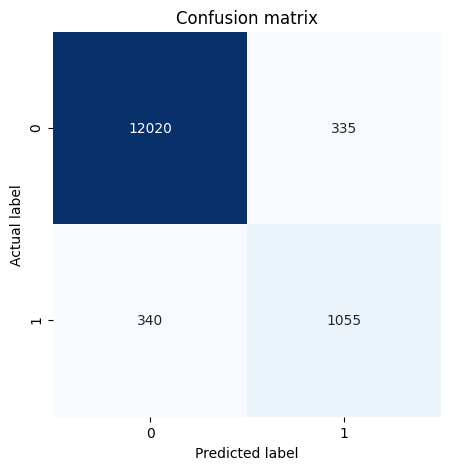

In [15]:
# Тестирование модели
predictions = lr_cv.best_estimator_.predict(features_test)
probabilities = lr_cv.best_estimator_.predict_proba(features_test)[:, 1]

# Оценка метрик на тестовой выборке
f1 = f1_score(target_test, predictions)
precision = precision_score(target_test, predictions)
recall = recall_score(target_test, predictions)
accuracy = accuracy_score(target_test, predictions)
roc_auc = roc_auc_score(target_test, probabilities)

print(f'F1: {f1:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'Accuracy: {accuracy:.3f}')
print(f'ROC-AUC: {roc_auc:.3f}')

# Отрисовка матрицы ошибок
matrix = confusion_matrix(target_test, predictions)

plt.figure(figsize=(5, 5))
sns.heatmap(matrix, annot=True, fmt='d', cbar=False, cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


Из матрицы ошибок можно сделать следующие выводы:

* У модели большое количество верно предсказанных отрицательных ответов (true negatives), что говорит о её хорошей способности определять отсутствие целевого события.

* Модель также верно предсказывает положительные ответы (true positives), хотя и с меньшей точностью.

* Количество ошибок не является критически высоким.

В целом, можно считать, что модель имеет хорошее качество классификации.

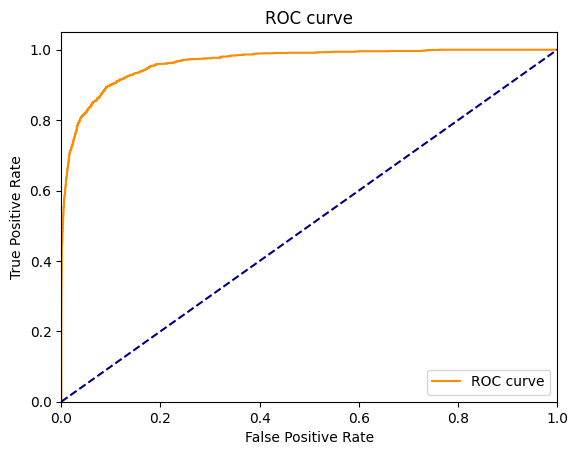

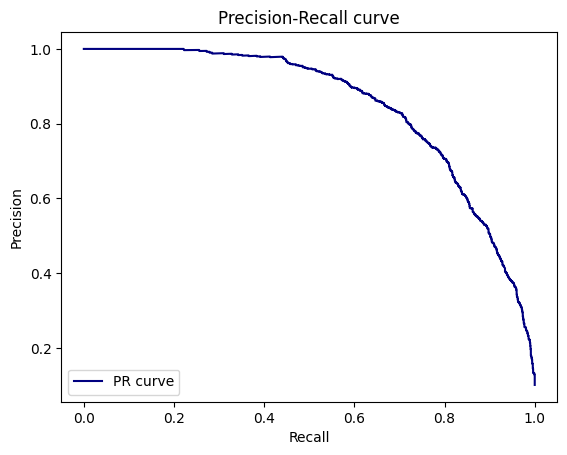

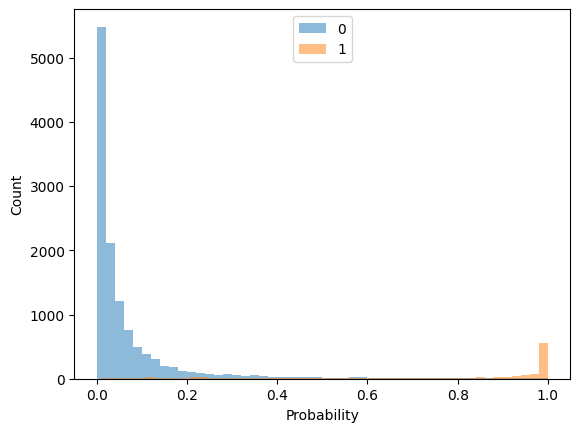

In [20]:
# Получаем вероятности принадлежности к классу 1
probas_lr = lr_cv.predict_proba(features_test)[:, 1]

# Строим ROC-кривую
fpr, tpr, thresholds = roc_curve(target_test, probabilities)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

# Строим Precision-Recall кривую
precision, recall, thresholds = precision_recall_curve(target_test, probabilities)
plt.plot(recall, precision, color='navy', label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()

# Строим гистограмму распределения вероятностей принадлежности к классу 1
plt.hist(probabilities[target_test == 0], bins=50, alpha=0.5, label='0')
plt.hist(probabilities[target_test == 1], bins=50, alpha=0.5, label='1')
plt.legend(loc='upper center')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()

Проверим модель на адекватность с помощью `DummyClassifier`

In [21]:
# Создаем dummy-модель
dummy_clf = DummyClassifier(strategy='uniform', random_state=RANDOM_STATE)

dummy_clf.fit(features_train, target_train)
dummy_predictions = dummy_clf.predict(features_test)

print("F1-score для dummy-модели:", f1_score(target_test, dummy_clf.predict(features_test)))
print("F1-score для logistic regression:", f1_score(target_test, lr_cv.predict(features_test)))

F1-score для dummy-модели: 0.17431527693244064
F1-score для logistic regression: 0.7576301615798924


На основе проведенного анализа текстовых данных было построено несколько моделей машинного обучения: `Logistic Regression`, `Decision Tree Classifier`, `Random Forest Classifier`, `Cat Boost Classifier`. При этом на кросс-валидации лучшую метрику F1 `0.761` показала модель `Logistic Regression`.

Был проведен процесс подбора гиперпараметров модели `Logistic Regression` с использованием `GridSearchCV`, что позволило получить значения параметров: `{'model__C': 8, 'tfidf__max_df': 0.25, 'tfidf__ngram_range': (1, 2)}`. После этого была проведена проверка модели на тестовой выборке, которая дала следующие метрики: 

* F1 - `0.758`
* Precision - `0.759`
* Recall - `0.756`
* Accuracy - `0.951`
* ROC-AUC: 0.965

Для проверки адекватности модели была использована `dummy-модель`, которая выдала метрику F1 - `0.17`. Модель `Logistic Regression` в данном случае дала гораздо лучший результат F1 - `0.758`, что позволяет сделать вывод о том, что модель является адекватной и может быть использована для решения задачи классификации текстовых данных.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны